In [322]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import plotly.graph_objects as go
from ta.trend import MACD
from ta.volatility import BollingerBands

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve


from matplotlib import pyplot as plt

pd.get_option("display.max_columns")

20

In [323]:
import random

seed_to_use = 42
test_size = 0.1
random.seed(seed_to_use)
np.random.seed(seed_to_use)

In [324]:
from IPython.core.display import display, HTML
from IPython.display import Image
%pylab inline

display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


/Users/viktor/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['split', 'datetime', 'random', 'draw']
`%matplotlib` prevents importing * from pylab and numpy



In [ ]:
! pip install lightgbm

In [247]:
def load_configs(config: str = "btc"):
    is_time_aggregate = False
    if config == "btc":
        filename = "test.csv"
        trades_per_candle = 1000
        do_aggregate = False
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy"])
    elif config == "etc":        
        filename = "test_ethusd.csv"
        trades_per_candle = 1000
        do_aggregate = True
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy"])
    else:
        filename = "test_ethusdt_time_series.csv"
        trades_per_candle = 1000
        do_aggregate = False
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy", "Trades"])
        is_time_aggregate = True
    # threshold = 0.15
    threshold = 0.
    return filename, trades_per_candle, do_aggregate, threshold, df, is_time_aggregate

filename, trades_per_candle, do_aggregate, threshold, df, is_time_aggregate = load_configs("else")

In [248]:
df

,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades
0,2900.48,2903.03,2899.28,2902.23,5.644723e+05,1632825034524,140,361
1,2902.08,2902.23,2894.81,2896.95,8.312620e+05,1632825094911,250,431
2,2896.99,2902.34,2896.99,2901.09,5.649050e+05,1632825155495,162,284
3,2901.34,2904.62,2900.80,2904.62,3.378702e+05,1632825215565,99,251
4,2904.63,2906.77,2903.32,2905.66,8.657689e+05,1632825275747,230,469
...,...,...,...,...,...,...,...,...
5160,3277.10,3277.32,3272.23,3272.23,6.035946e+05,1633146328831,340,611
5161,3272.26,3272.62,3268.24,3270.77,9.157132e+05,1633146388838,403,840
5162,3271.00,3274.13,3270.56,3271.77,1.068848e+06,1633146449294,265,588
5163,3272.13,3272.48,3269.46,3271.14,8.007611e+05,1633146509683,208,611


In [249]:
df["Timestamp"] = df["Timestamp"].apply(lambda row: pd.to_datetime(row,unit='ms'))

def draw(df):
    fig = go.Figure(data=[go.Candlestick(x=df['Timestamp'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()
draw(df)

In [250]:
def aggregate(each: int = 10):
    new_df = pd.DataFrame()
    new_df["Open"] = df["Open"].groupby(df.index // each).first()
    new_df["High"] = df["High"].groupby(df.index // each).max()
    new_df["Low"] = df["Low"].groupby(df.index // each).min()
    new_df["Close"] = df["Close"].groupby(df.index // each).last()
    new_df["Volume"] = df["Volume"].groupby(df.index // each).sum()
    new_df["Timestamp"] = df["Timestamp"].groupby(df.index // each).min()
    new_df["SelltoBuy"] = df["SelltoBuy"].groupby(df.index // each).sum()
    return new_df

if do_aggregate:
    new_df = aggregate()

In [251]:
if do_aggregate:
    df = new_df
    draw(df)

In [252]:
df.tail(50)

,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades
5115,3290.83,3290.83,3288.01,3288.05,4.238561e+05,2021-10-02 02:59:09.267,171,311
5116,3288.05,3289.99,3285.74,3286.28,5.568193e+05,2021-10-02 03:00:09.270,315,562
5117,3286.29,3290.34,3285.88,3290.14,7.026344e+05,2021-10-02 03:01:09.433,372,651
5118,3290.15,3291.65,3288.49,3291.31,7.445698e+05,2021-10-02 03:02:09.689,310,637
5119,3291.30,3292.32,3290.14,3290.39,4.874234e+05,2021-10-02 03:03:10.471,167,410
5120,3290.40,3292.20,3288.83,3291.60,7.731934e+05,2021-10-02 03:04:10.529,165,518
5121,3291.29,3293.33,3289.04,3289.04,5.524171e+05,2021-10-02 03:05:10.727,143,384
5122,3289.05,3291.71,3289.04,3290.45,1.268785e+05,2021-10-02 03:06:12.451,86,257
5123,3290.44,3295.57,3290.44,3294.66,3.702931e+05,2021-10-02 03:07:12.530,115,478
5124,3294.67,3295.00,3287.00,3287.40,6.563628e+05,2021-10-02 03:08:12.702,285,545


In [253]:
# df.to_csv('ethbtc.csv', index=False)

In [254]:
def create_signal(signal_col_name:str = "simple_signal", buy_side_col:str = "pct_change", sell_side_col:str = "pct_change"):
    conditions = [(df[buy_side_col] > threshold), (df[sell_side_col] < -threshold)]
#     choices = [1, -1]
    choices = [1, 0]
    df[signal_col_name] = np.select(conditions, choices, default=0)


def signal_analytics(signal_col_name: str = "simple_signal"):
    signals_total = df[signal_col_name][df[signal_col_name] != 0].count()
    df_len = len(df)
    print(f"Buy signals total: {df[signal_col_name][df[signal_col_name] > 0].sum()}")
    print(f"Sell signals total: {abs(df[signal_col_name][df[signal_col_name] < 0].sum())}")
    print(f"Signals total: {signals_total}")
    print(f"Candles observed: {df_len}")
    print(f"Signal to candle ratio: {round(signals_total/df_len, 4)*100}%")


In [260]:
df['return'] = np.log(df["Close"] / df["Close"].shift(1))
df['direction'] = np.where(df['return'] > 0, 1, 0)
df.dropna(inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades,return,direction
5160,3277.10,3277.32,3272.23,3272.23,6.035946e+05,2021-10-02 03:45:28.831,340,611,-0.001487,0
5161,3272.26,3272.62,3268.24,3270.77,9.157132e+05,2021-10-02 03:46:28.838,403,840,-0.000446,0
5162,3271.00,3274.13,3270.56,3271.77,1.068848e+06,2021-10-02 03:47:29.294,265,588,0.000306,1
5163,3272.13,3272.48,3269.46,3271.14,8.007611e+05,2021-10-02 03:48:29.683,208,611,-0.000193,0
5164,3271.15,3272.24,3269.56,3270.52,4.816430e+05,2021-10-02 03:49:30.134,192,447,-0.000190,0


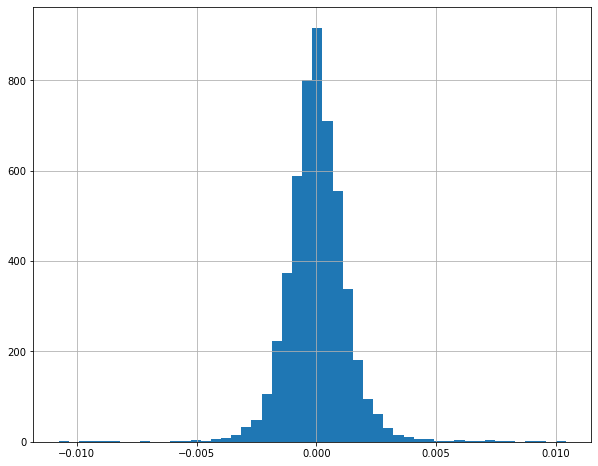

In [261]:
df['return'].hist(bins=50, figsize=(10, 8));

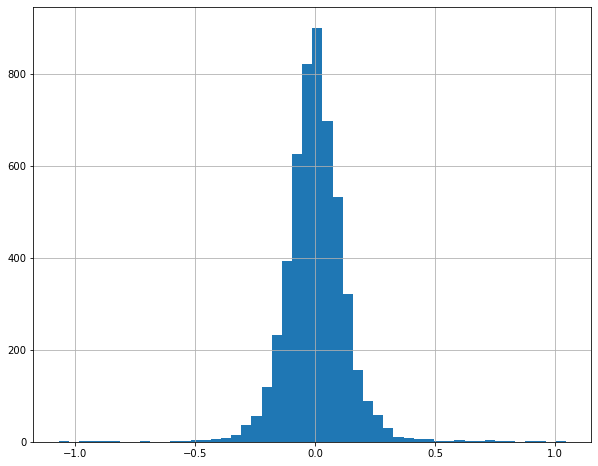

In [262]:
(df["Close"].pct_change() * 100).hist(bins=50, figsize=(10, 8));

In [264]:
indicator_bb = BollingerBands(close=df['Close'], window=20, window_dev=2)
df['bb_bbm'] = indicator_bb.bollinger_mavg()
df['bb_bbh'] = indicator_bb.bollinger_hband()
df['bb_bbl'] = indicator_bb.bollinger_lband()



indicator_macd = MACD(close = df['Close'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False)
df['macd'] = indicator_macd.macd()
df['macd_diff'] = indicator_macd.macd_diff()
df['macd_signal'] = indicator_macd.macd_signal()

In [265]:
df['momentum'] = df['return'].rolling(5).mean().shift(1)
df['volatility'] = df['return'].rolling(20).std().shift(1)
df['distance'] = (df['Close'] - df['Close'].rolling(50).mean()).shift(1)

In [266]:
df['open_high_pct_change'] = ((df['High'] - df['Open']) / df['Open'] * 100).shift(1)
df['open_low_pct_change'] = ((df["Low"] - df["Open"]) / df["Open"] * 100).shift(1)
df["sell_to_buy_ratio"] = ((df["SelltoBuy"] / trades_per_candle) if not is_time_aggregate else df["SelltoBuy"] / df["Trades"]).shift(1)

In [267]:
def introduce_shift(depth: int = 1):
    for i in range(depth):
        df[f"pct_change_{i+1}"] = df["return"].shift(i+1)
        df[f"open_high_pct_change_{i+1}"] = df["open_high_pct_change"].shift(i+1)
        df[f"open_low_pct_change_{i+1}"] = df["open_low_pct_change"].shift(i+1)
        df[f"sell_to_buy_ratio_{i+1}"] = df["sell_to_buy_ratio"].shift(i+1)

In [274]:
df['High_shift'] = df['High'].shift(1)
df['Low_shift'] = df['Low'].shift(1)
df.drop(columns=['High', 'Low'], inplace=True)

In [ ]:
introduce_shift(5)
df.dropna(inplace=True)

In [276]:
df.columns

Index(['Open', 'Close', 'Volume', 'Timestamp', 'SelltoBuy', 'Trades', 'return',
       'direction', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'macd', 'macd_diff',
       'macd_signal', 'momentum', 'volatility', 'distance',
       'open_high_pct_change', 'open_low_pct_change', 'sell_to_buy_ratio',
       'pct_change_1', 'open_high_pct_change_1', 'open_low_pct_change_1',
       'sell_to_buy_ratio_1', 'pct_change_2', 'open_high_pct_change_2',
       'open_low_pct_change_2', 'sell_to_buy_ratio_2', 'pct_change_3',
       'open_high_pct_change_3', 'open_low_pct_change_3',
       'sell_to_buy_ratio_3', 'pct_change_4', 'open_high_pct_change_4',
       'open_low_pct_change_4', 'sell_to_buy_ratio_4', 'pct_change_5',
       'open_high_pct_change_5', 'open_low_pct_change_5',
       'sell_to_buy_ratio_5', 'High_shift', 'Low_shift'],
      dtype='object')

In [287]:
features_list = [ 

 'bb_bbm',
 'bb_bbh',
 'bb_bbl',
 'macd',
 'macd_diff',
 'macd_signal',
 'momentum',
 'volatility',
'distance',
       'open_high_pct_change', 'open_low_pct_change', 'sell_to_buy_ratio',
       'pct_change_1', 'open_high_pct_change_1', 'open_low_pct_change_1',
       'sell_to_buy_ratio_1', 'pct_change_2', 'open_high_pct_change_2',
       'open_low_pct_change_2', 'sell_to_buy_ratio_2', 'pct_change_3',
       'open_high_pct_change_3', 'open_low_pct_change_3',
       'sell_to_buy_ratio_3', 'pct_change_4', 'open_high_pct_change_4',
       'open_low_pct_change_4', 'sell_to_buy_ratio_4', 'pct_change_5',
       'open_high_pct_change_5', 'open_low_pct_change_5',
       'sell_to_buy_ratio_5', 'High_shift', 'Low_shift'
]

In [288]:
df.isnull().sum()

Open                      0
Close                     0
Volume                    0
Timestamp                 0
SelltoBuy                 0
Trades                    0
return                    0
direction                 0
bb_bbm                    0
bb_bbh                    0
bb_bbl                    0
macd                      0
macd_diff                 0
macd_signal               0
momentum                  0
volatility                0
distance                  0
open_high_pct_change      0
open_low_pct_change       0
sell_to_buy_ratio         0
pct_change_1              0
open_high_pct_change_1    0
open_low_pct_change_1     0
sell_to_buy_ratio_1       0
pct_change_2              0
open_high_pct_change_2    0
open_low_pct_change_2     0
sell_to_buy_ratio_2       0
pct_change_3              0
open_high_pct_change_3    0
open_low_pct_change_3     0
sell_to_buy_ratio_3       0
pct_change_4              0
open_high_pct_change_4    0
open_low_pct_change_4     0
sell_to_buy_ratio_4 

In [289]:
df.head()

,Open,Close,Volume,Timestamp,SelltoBuy,Trades,return,direction,bb_bbm,bb_bbh,...,pct_change_4,open_high_pct_change_4,open_low_pct_change_4,sell_to_buy_ratio_4,pct_change_5,open_high_pct_change_5,open_low_pct_change_5,sell_to_buy_ratio_5,High_shift,Low_shift
0,2922.86,2922.57,2.253722e+05,2021-09-28 11:26:59.990,134,261,-0.000096,0,2916.7900,2929.869116,...,-0.000229,0.228276,-0.019508,0.427890,0.001628,0.116697,-0.016769,0.454545,2926.21,2922.13
1,2922.58,2923.96,1.433948e+06,2021-09-28 11:27:59.992,326,694,0.000475,1,2917.7390,2929.980219,...,-0.000694,0.062529,-0.090547,0.526427,-0.000229,0.228276,-0.019508,0.427890,2924.38,2922.09
2,2923.96,2925.44,1.239700e+06,2021-09-28 11:29:00.005,330,598,0.000506,1,2918.5965,2930.467076,...,0.000079,0.006494,-0.234119,0.522003,-0.000694,0.062529,-0.090547,0.526427,2927.62,2921.30
3,2925.44,2939.47,5.762629e+06,2021-09-28 11:30:00.071,1884,3404,0.004784,1,2920.1075,2934.300712,...,-0.000458,0.030095,-0.114564,0.444934,0.000079,0.006494,-0.234119,0.522003,2926.83,2922.88
4,2939.46,2934.00,1.441110e+06,2021-09-28 11:31:00.080,650,1046,-0.001863,0,2921.1530,2936.180516,...,-0.000096,0.069079,-0.070447,0.487465,-0.000458,0.030095,-0.114564,0.444934,2940.74,2924.19


In [295]:
sclaing_features = ['High_shift', 'Low_shift']
non_sclaing_features = [f for f in features_list if f not in sclaing_features]
df = df.fillna(0).reset_index(drop=True)

In [298]:
X = df[features_list]
y = df['direction']

split = int(0.85*len(df))
_X_train, X_test, _y_train, y_test = X[:split], X[split:], y[:split], y[split:]
X_train, X_valid, y_train, y_valid = X[:split], X[split:], y[:split], y[split:]

In [299]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))
training_set_scaled = sc.fit_transform(X_train[sclaing_features])

test_set_scaled = sc.transform(X_test[sclaing_features])
valid_set_scaled = sc.transform(X_valid[sclaing_features])

In [300]:
def concat_scale(data, scale_data):
    data_scaled = pd.DataFrame(scale_data, columns = sclaing_features)
    data_out = pd.concat([data_scaled, 
                      data.loc[:, non_sclaing_features].reset_index(drop=True)
                     ], axis=1)
    
    return data_out

In [301]:
X_train = concat_scale(X_train, training_set_scaled)
X_valid = concat_scale(X_valid, valid_set_scaled)
X_test = concat_scale(X_test, test_set_scaled)

In [ ]:


def value_to_color(val):
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation


    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]


def heatmap(x, y, corr_value):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=corr_value.abs() * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
    
    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=corr_value.abs() * size_scale,
        c=corr_value.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s'
    )
    

def draw_corr_heatmap(data):

    


    corr = data.corr()
    corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr.columns = ['x', 'y', 'value']
    heatmap(
        x=corr['x'],
        y=corr['y'],
        corr_value=corr['value']
    )





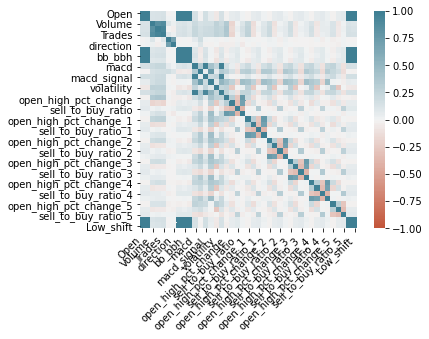

In [325]:

corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

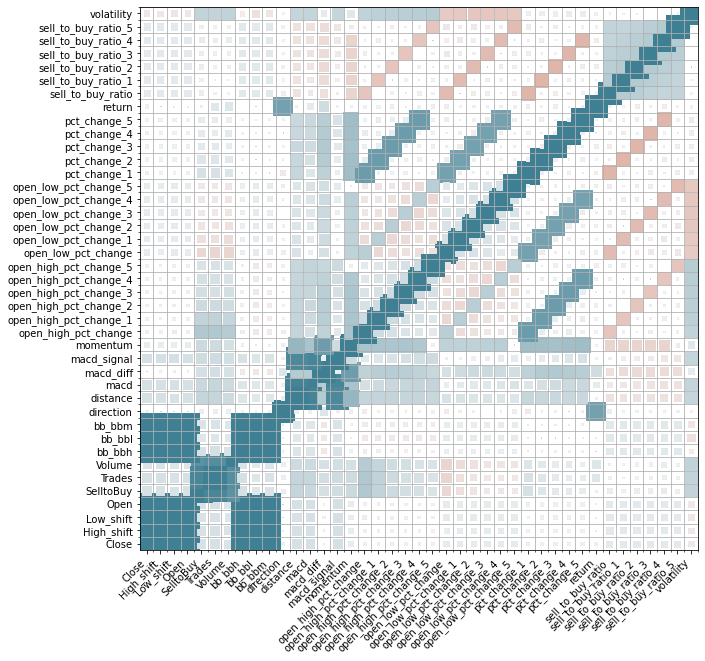

In [326]:
draw_corr_heatmap(data=df)

In [302]:


# model = LogisticRegression(C=1e7, solver='lbfgs',
#                                      multi_class='auto',
#                                      max_iter=10000)

model = LogisticRegression(C=1e7, solver='liblinear',
                                    class_weight='balanced',
                                     multi_class='auto',
                                     max_iter=10000,
                                       penalty='l1')#, l1_ratio=0.3)

model = model.fit (X_train,y_train)

model.score(X_test, y_test)

/Users/viktor/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



0.8383311603650587

In [303]:
cross_val = cross_val_score(linear_model.LogisticRegression(), X, y, scoring='accuracy', cv=10)
cross_val
cross_val.mean()

/Users/viktor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/viktor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/viktor/op

0.7369394881240168

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       380
           1       0.81      0.90      0.85       387

    accuracy                           0.84       767
   macro avg       0.84      0.84      0.84       767
weighted avg       0.84      0.84      0.84       767


Accuracy
0.8383311603650587


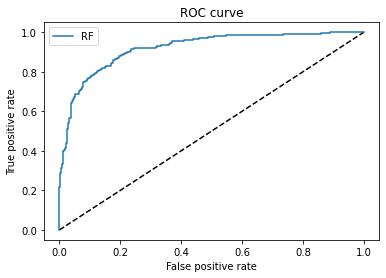

In [304]:


# Performance Metrics
y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [310]:
def model_train(X_train, y_train):
    model = RandomForestClassifier(n_estimators=500, max_depth=4)
#     model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=0)
#     model = LogisticRegression(multi_class='ovr', penalty="elasticnet", l1_ratio=0.5, C=0.01, solver="saga")
#     model = LogisticRegression(multi_class='ovr', solver="liblinear", penalty="l1", C=10)
#     model = LogisticRegression(multi_class='ovr', solver="liblinear", penalty="l1", C=0.1)
#     model = SVC(C=0.1, gamma="auto", class_weight="balanced")
        
#     make_pipeline(StandardScaler(), SVC(gamma='auto'))
#     model = LogisticRegression(multi_class='ovr', C=0.01)
#     model = make_pipeline(StandardScaler(), model)
    model.fit(X_train, y_train)
    return model

model_s = model_train(X_train, y_train)
# model_tp = model_train(X_train_tp, y_train_tp)

def model_predict_evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    
model_predict_evaluate(model_s, X_train, y_train)
# model_predict_evaluate(model_tp, X_train_tp, y_train_tp)

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      2169
           1       0.66      0.65      0.65      2173

    accuracy                           0.66      4342
   macro avg       0.66      0.66      0.66      4342
weighted avg       0.66      0.66      0.66      4342



In [311]:
model_predict_evaluate(model_s, X_test, y_test)
# model_predict_evaluate(model_tp, X_test_tp, y_test_tp)

              precision    recall  f1-score   support

           0       0.53      0.65      0.59       380
           1       0.56      0.44      0.49       387

    accuracy                           0.54       767
   macro avg       0.55      0.55      0.54       767
weighted avg       0.55      0.54      0.54       767



In [313]:
def LGBM_model(X_train, y_train):
    dftrainLGB = lgb.Dataset(data = X_train, label = y_train) # feature_name = "auto", categorical_feature="auto")

        """
        params = {'objective': 'multiclass',
                 'max_depth': 3,
                 'learning_rate': 0.1,
                 'num_leaves': 10,
                 'multiclassova': 'multi_logloss',
                  'class_weight': 'balanced',
                 #'num_class': len(np.unique(y_train))
                 }
        """

        params = {'objective': 'binary',
                 'max_depth': 4,
                 'learning_rate': 0.1,
                 'num_leaves': 10,
                 'pos_bagging_fraction': 0.5,
                 'neg_bagging_fraction': 0.3,
                 'num_iterations': 400,
                 'class_weight': 'balanced'}
        
    lgb_final = lgb.LGBMClassifier(**params).fit(X_train, y_train)
    return lgb_final

In [314]:
lgb_final = LGBM_model(X_train, y_train )

/Users/viktor/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



In [316]:
model_predict_evaluate(lgb_final, X_train, y_train)
# model_predict_evaluate(lgb_final, X_train_tp, y_train_tp)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2169
           1       0.96      0.95      0.96      2173

    accuracy                           0.96      4342
   macro avg       0.96      0.96      0.96      4342
weighted avg       0.96      0.96      0.96      4342



In [317]:
model_predict_evaluate(lgb_final, X_test, y_test)
# model_predict_evaluate(lgb_final, X_test_tp, y_test_tp)

              precision    recall  f1-score   support

           0       0.58      0.48      0.52       380
           1       0.56      0.67      0.61       387

    accuracy                           0.57       767
   macro avg       0.57      0.57      0.57       767
weighted avg       0.57      0.57      0.57       767



<BarContainer object of 34 artists>

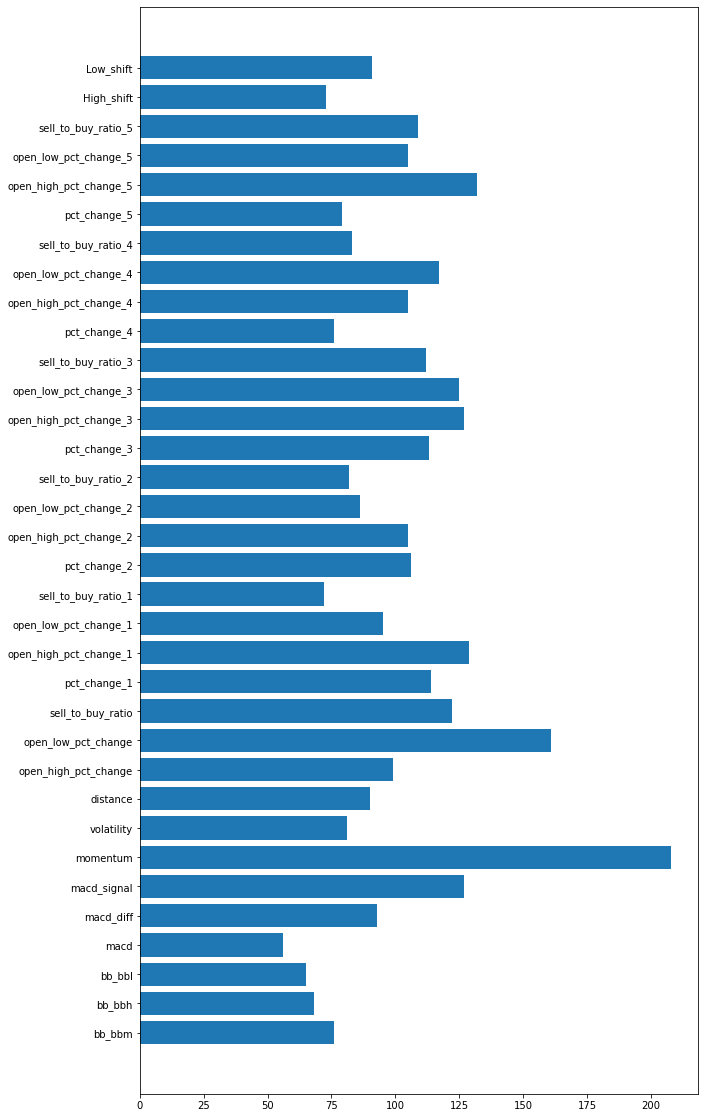

In [320]:
plt.figure(figsize=(10,20))
plt.barh(list(X), lgb_final.feature_importances_)

<BarContainer object of 34 artists>

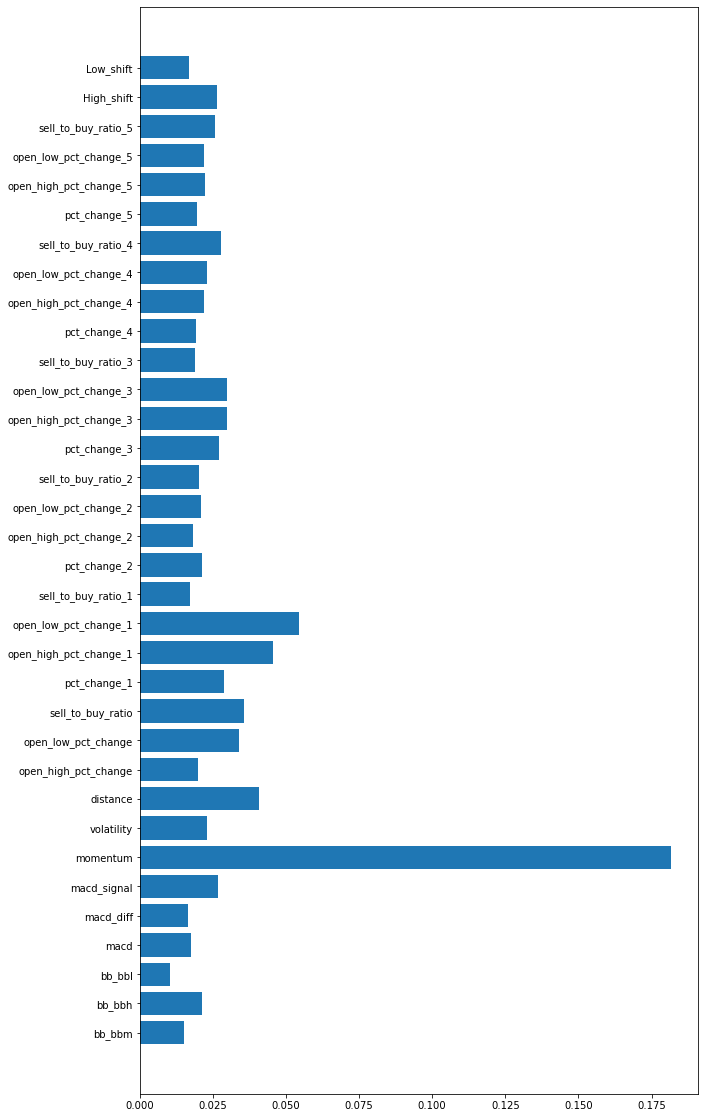

In [321]:
plt.figure(figsize=(10,20))
plt.barh(list(X), model_s.feature_importances_)

In [49]:
# TODO:
# 1. Think on a model that would make for a good demo. There are several options:
#  a. Have labels that are related to some window in which the price changes significantly enough.
# We can reuse existing aggregations for such model.
#  b. Have a higher resolution of the aggregations (10k events instead of 1000 events for BTC). Can post-process existing data
# in fine resolution to arrive at new aggregations using a Python script.
#  c. Select a high-volume and high-volatility pair (e.g. ETHUSDT) that would yield signals more often.

In [50]:
# df.dropna(inplace=True)

In [51]:
# df.to_csv('ethbtc.csv', index=False)